# Week8 - Decision Tree, KNN, NB, SVM Homework

* Do a quick EDA to understand your data and explain what you need for your pipeline.
* Explain what metric would be appropriate for this task (1 sentence).
* Explain your game plan
* Create a preprocessing pipeline (without the model).

* Train-test split
* Create pipelines for the following models and use preprocessing pipeline you created in the previous step
    - Decision Trees
    - Random Forests
    - KNN
    - NB
    - SVM
  
* Define params for GridSearchCV for all models
* Evaluate the models

* Explain findings

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [180]:
# DON'T CHANGE ANYTHING HERE....
random.seed(42)
def remove_values(df, cols, perc=0.001):
    for i in cols:
        mask = pd.Series(random.choices([0,1], weights=[perc, 1-perc], k=len(df[i])))
        df[i] = [ x if i==1 else None for x, i in zip(df[i], mask)]

def create_df(size=1000000):
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_samples=size,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_classes=2,
        flip_y=0.2,
        random_state=4
    )

    df = pd.DataFrame(X)
    df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    df.f1 = df.f1**2
    df.f2 = df.f2**2
    df.f3 = df.f3*1000

    flag = random.choices([True, False], weights=[0.65, 0.35], k=len(y))
    f6 = ['A' if i == 0 else 'B' for i in y]

    f6 = [f if i else ('B' if f=='A' else 'A') for i,f in zip(flag, f6)]
    df['f6'] = f6

    remove_values(df, df.columns, perc=0.05)

    return df, pd.Series(y)

X, y = create_df()

In [181]:
# eda code
X.head()

,f1,f2,f3,f4,f5,f6
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,B
1,NaN,1.764094,-873.709051,2.084035,0.387268,A
2,8.663599,NaN,-563.461158,-0.044922,2.512673,A
3,NaN,3.899908,753.129656,1.565944,-3.771516,A
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,A


In [182]:
X.tail()

,f1,f2,f3,f4,f5,f6
999995,0.166039,0.373037,-949.377892,1.474729,0.025967,B
999996,0.000004,4.528094,565.707592,0.675330,-1.407992,B
999997,0.586368,2.744505,-159.971366,1.249234,-0.400789,B
999998,2.354836,1.503345,2383.670899,0.822951,2.036277,B
999999,0.373415,0.142062,-859.153052,1.460491,-0.084982,A


In [183]:
X.dtypes

,0
f1,float64
f2,float64
f3,float64
f4,float64
f5,float64
f6,object


In [184]:
X.describe()

,f1,f2,f3,f4,f5
count,9.499330e+05,9.498840e+05,949804.000000,950444.000000,950149.000000
mean,2.970269e+00,2.698242e+00,1.203865,-0.002337,-0.000394
std,4.223559e+00,3.863111e+00,1441.308642,1.682211,1.683646
min,7.464873e-15,4.200556e-12,-6319.721066,-8.364699,-7.067953
25%,3.265102e-01,3.144912e-01,-1077.181298,-1.172712,-1.186616
50%,1.415231e+00,1.310581e+00,-403.563631,0.067817,0.001923
75%,3.905995e+00,3.501739e+00,1009.950057,1.156616,1.152483
max,9.069379e+01,8.512300e+01,7402.596849,9.717087,8.354947


In [185]:
X.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6'], dtype='object')

In [186]:
X.sample(5)

,f1,f2,f3,f4,f5,f6
690357,0.096195,0.114296,-1230.698824,2.270894,-1.317836,A
472887,0.528291,0.464198,-1581.026914,1.034433,1.082642,A
209453,2.827442,0.027802,-1370.505897,-2.548453,-0.422641,None
726102,1.264621,1.162120,1920.199929,0.168906,1.843304,A
434838,2.788217,1.708342,-637.424017,-1.551064,NaN,A


<Axes: >

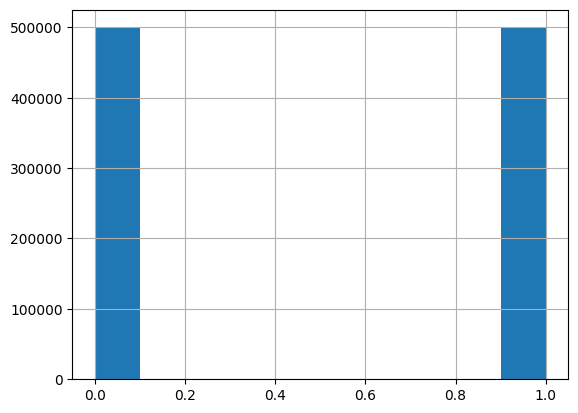

In [187]:
y.hist()

In [188]:
X.isna().sum()

,0
f1,50067
f2,50116
f3,50196
f4,49556
f5,49851
f6,50017


<Axes: >

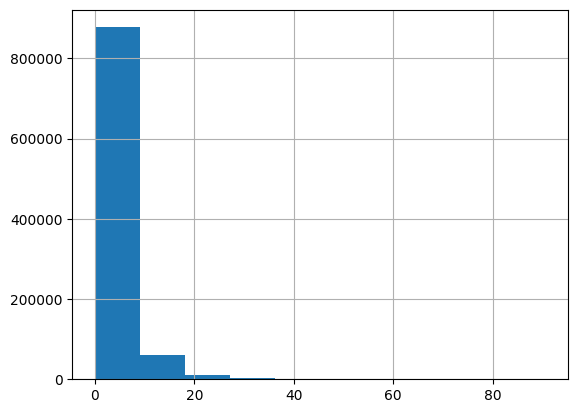

In [189]:
X.f1.hist()

<Axes: >

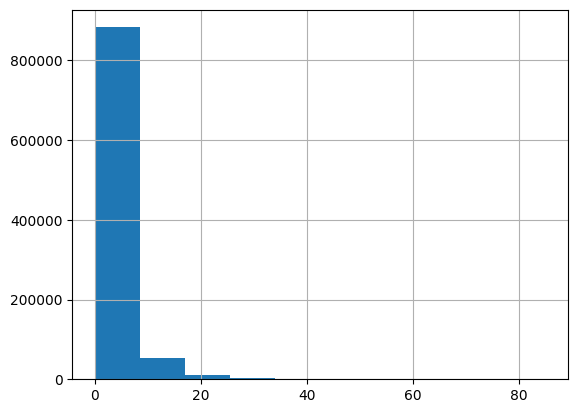

In [190]:
X.f2.hist()

<Axes: >

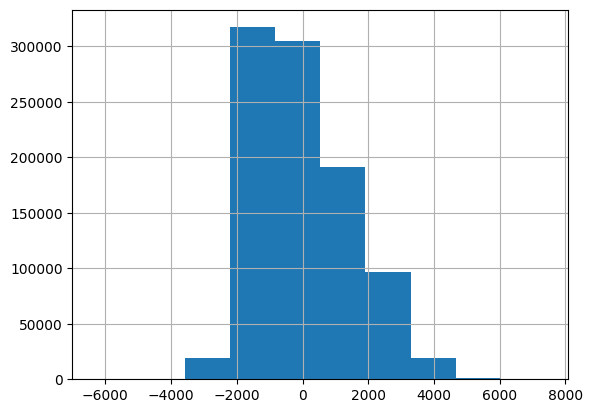

In [191]:
X.f3.hist()

<Axes: >

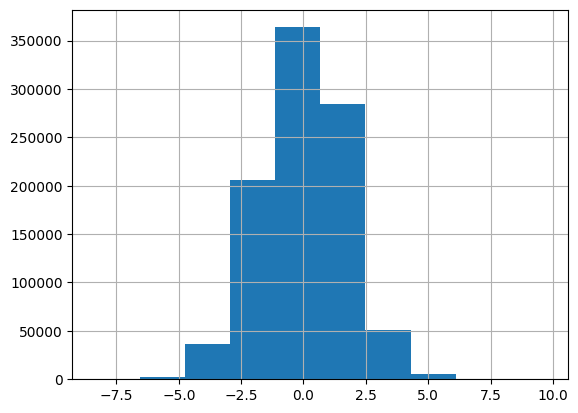

In [192]:
X.f4.hist()

<Axes: >

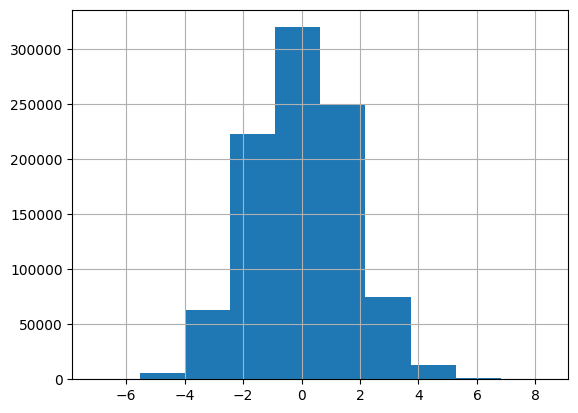

In [193]:
X.f5.hist()

<Axes: >

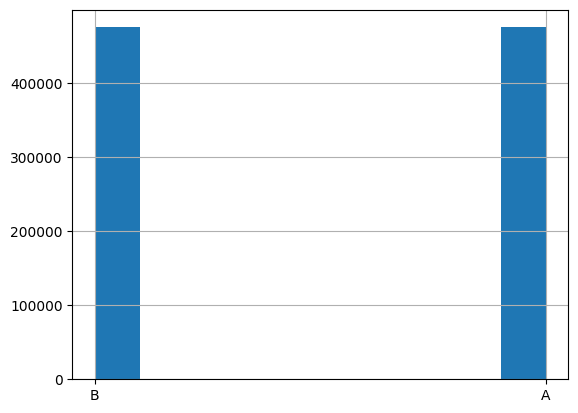

In [194]:
X.f6.hist()

Explainations...

1. We need to use meadian and mode to fill the missing values which is around 5%.
2. Observed in f1 and f2 that the values present are smaller comparatively and some are extremely high.
3. f3 values are large.
4. we have only categorical value and rest are all numerical.

**metric: f1**

The F1-score is the best metric because the classes aren't evenly balanced and the labels aren't always accurate. Both accurate forecasts and those the model misses are given equal weight.

Explain your gameplan...

1. cleaning the data and handling the missing values.
2. select features for the model and create pipelines.
3. split the data into test and train
4. work with some models and see which fits best.

In [195]:
# create processing pipeline
# numerical_vars = []
# categorical_Vars = []
Numerical = [col for col in X.columns if X[col].dtype == 'float64']
Categorical = [col for col in X.columns if X[col].dtype == 'object']
print('numerical_vars:', Numerical)
print('categorical_Vars:', Categorical)

numerical_vars: ['f1', 'f2', 'f3', 'f4', 'f5']
categorical_Vars: ['f6']


In [196]:
numerical_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])
categorical_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('encoder', OneHotEncoder(handle_unknown='ignore'))])
processing_pipeline = ColumnTransformer(transformers=[('num', numerical_transform, Numerical),('cat', categorical_transform, Categorical)])

## HW

Some of the stub code added. Complete it and add the code for the missing models.

In [197]:
Xs = X[:10000]
ys= y[:10000]

<Axes: >

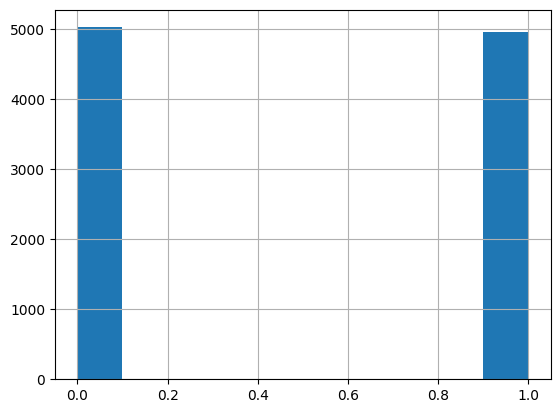

In [198]:
ys.hist()

In [199]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)

In [200]:
dt_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', DecisionTreeClassifier())])

In [201]:
dt_param_grid = [
    {
        'ml__max_depth' : [5, 10 ,15]
    }
]

scoring ='f1'

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train, y_train)

In [202]:
dt_gcv_results.best_params_

{'ml__max_depth': 10}

In [203]:
dt_gcv_results.score(X_train, y_train)

0.8839681133746679

In [204]:
dt_gcv_results.score(X_test, y_test)

0.775169535732916

Explain __shortly__ your findings how did you address the issues.

Based on the input features, the Decision Tree model made intelligent decisions and performed really well. To begin with, although it had some difficulty with the confused or inaccurate labels, it managed to maintain a decent balance between memory and precision. In the end if we consider all the things it looks good, but more complex models like ensembles can work more better.

In [205]:
rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', RandomForestClassifier())])

In [206]:
rf_param_grid = [
    {
      'ml__max_depth' : [5, 10],
      'ml__n_estimators':[50,100]
    }
]

scoring = 'f1'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)

In [207]:
rf_gcv_results.best_params_

{'ml__max_depth': 10, 'ml__n_estimators': 100}

In [208]:
rf_gcv_results.score(X_train, y_train)

0.8736961166268694

In [209]:
rf_gcv_results.score(X_test, y_test)

0.8043254376930999

Explain __shortly__ your findings how did you address the issues.

Overall, the Random Forest is such a model that works best for working with imbalanced. messy, real-world data. It does a good job in multiple areas like capturing both positive cases and negative cases, noisy labels, handling missing data, and class imbalance with ease, and scoring highly on the F1-score.

In [210]:
from sklearn.neighbors import KNeighborsClassifier

knn_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', KNeighborsClassifier())]
)
knn_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', KNeighborsClassifier())])

In [211]:
knn_param_grid = [{
    'ml__weights': ['uniform', 'distance'],
    'ml__n_neighbors': [3, 5, 7]
}]

scoring = 'f1'

knn_gc = GridSearchCV(estimator=knn_modeling_pipeline, param_grid=knn_param_grid, cv=5, scoring=scoring)
knn_gcv_results = knn_gc.fit(X_train, y_train)

In [212]:
knn_gcv_results.best_params_

{'ml__n_neighbors': 7, 'ml__weights': 'uniform'}

In [213]:
knn_gcv_results.score(X_train, y_train)

0.849936948297604

In [214]:
knn_gcv_results.score(X_test, y_test)

0.8094262295081968

The KNN model produced good, acceptable results, but it had trouble noisy labels. It works with dataset well but lacks in flexibility when it comes to optimal performance. In KNN it looks at the close data points, therefore using 3 neighbors produced the best results.

In [215]:
from sklearn.naive_bayes import GaussianNB

naiveb_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', GaussianNB())]
)
naiveb_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', GaussianNB())])

In [216]:
naiveb_param_grid = [{     }]

scoring = 'f1'

naiveb_gc = GridSearchCV(estimator=naiveb_modeling_pipeline, param_grid=naiveb_param_grid, cv=5, scoring=scoring)
naiveb_gcv_results = naiveb_gc.fit(X_train, y_train)

In [217]:
naiveb_gcv_results.best_params_

{}

In [218]:
naiveb_gcv_results.score(X_train, y_train)

0.702377972465582

In [219]:
naiveb_gcv_results.score(X_test, y_test)

0.7075180226570545

Naive bayes produced normal results. it works well depending on the dataset, meaning independent or normally distributed features can give better results. It doesn't function well in this case due to the nature of data.

In [220]:
from sklearn.svm import SVC

svm_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', SVC())]
)
svm_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', SVC())])

In [178]:
svm_param_grid = [{
    'ml__kernel': ['linear', 'rbf'],
    'ml__gamma': ['scale', 'auto'],
    'ml__C': [0.1, 1, 10]
}]

scoring = 'f1'

svm_gc = GridSearchCV(estimator=svm_modeling_pipeline, param_grid=svm_param_grid, cv=5, scoring=scoring)
svm_gcv_results = svm_gc.fit(X_train, y_train)

In [221]:
svm_gcv_results.best_params_

{'ml__C': 10, 'ml__gamma': 'auto', 'ml__kernel': 'rbf'}

In [222]:
svm_gcv_results.score(X_train, y_train)

0.8340807174887892

In [223]:
svm_gcv_results.score(X_test, y_test)

0.8177189409368636

when dealing with noisy data the svm worked well. it shows balance between precision and recall. does good when handling missing values too as it can differenciate well. yet its not fast and takes time to train when compared to other simple models.

Explain which model would you go with?

Random Forest.
1. easy model which gives good performance
2. flexible and good with handling missing values
3. more flexible, works with ease on large data and easy to interpret when compare with models like SVM, decision trees, naive bayes and knn.

In [224]:
# create a new pipeline with the winner model and the best params
# evaluate the same results

rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', RandomForestClassifier(n_estimators=200, max_depth=4))]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', RandomForestClassifier(max_depth=4, n_estimators=200))])

In [225]:
rf_param_grid = [{}]

scoring = 'f1'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)


In [226]:
rf_gcv_results.best_params_

{}

In [227]:
rf_gcv_results.score(X_train, y_train)

0.7730354004519207

In [228]:
rf_gcv_results.score(X_test, y_test)

0.7608695652173914

Explain results

Random forest is flexible, easy and gives good performance when it comes to anything like handling missing values, or complex patterns. it gave robust results and derives results by combining trees. It gives best results and fits the best in my opinion.